In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [15]:
df = pd.read_csv(r"C:\Users\User\Downloads\ISIC_2019_Training_GroundTruth.csv")

In [16]:
df.drop_duplicates()
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Types of Benign and malignant cancer 
We would gorup the types to 2 Categories - 

Malignant-
    1.Melanoma
    2.Basal cell carcinoma
    3.Actinic keratosis -  The patches are not usually serious / cancer
    4.Dermatofibroma -  Dermatofibromas are referred to as benign fibrous 
    5.Vascular lesion - may be benign (not cancer) or malignant (cancer) 
    6.Squamous cell carcinoma - In general, the squamous cell carcinoma survival rate is very high

Benign -    
    1.Melanocytic nevus
    2.Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)

In [17]:
df[['MEL','NV','BCC','AK','BKL','DF','VASC','SCC','UNK']].value_counts()

MEL  NV   BCC  AK   BKL  DF   VASC  SCC  UNK
0.0  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    12875
1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0     4522
0.0  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0     3323
          0.0  0.0  1.0  0.0  0.0   0.0  0.0     2624
               1.0  0.0  0.0  0.0   0.0  0.0      867
               0.0  0.0  0.0  0.0   1.0  0.0      628
                              1.0   0.0  0.0      253
                         1.0  0.0   0.0  0.0      239
dtype: int64

In [18]:
# Creating Label column to be used with the model

df['POSITIVE']=df['MEL']+df['BCC']+df['AK']+df['DF']+df['VASC']+df['SCC']+df['UNK']
df['NEGATIVE']=df['NV']+df['BKL']
df['LABEL']=df['POSITIVE']

In [19]:
df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,POSITIVE,NEGATIVE,LABEL
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
df['LABEL'].value_counts()

0.0    15499
1.0     9832
Name: LABEL, dtype: int64

# BALANCING

In [21]:
# Downsizing the benign type 

from sklearn.utils import resample

df_0 = df[df['LABEL'] == 0]
df_1 = df[df['LABEL'] == 1]

df_0_balanced = df_0.sample(9832) 



#Combined back to a single dataframe
df_balanced = pd.concat([df_0_balanced, df_1])

In [22]:
df_balanced['LABEL'].value_counts()

0.0    9832
1.0    9832
Name: LABEL, dtype: int64

In [23]:
df_balanced['LABEL']=df_balanced['LABEL'].astype(int)

In [24]:
df_balanced=df_balanced.sample(frac=1)
df_balanced=df_balanced.reset_index(drop=True)
df_balanced

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,POSITIVE,NEGATIVE,LABEL
0,ISIC_0031651,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,ISIC_0028102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,ISIC_0067274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,ISIC_0025044,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,ISIC_0032556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19659,ISIC_0027882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
19660,ISIC_0063669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
19661,ISIC_0072101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
19662,ISIC_0071295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [25]:
# Creating the path column for image name to concatinating with the dataset


df_balanced['folder']="C:\\Users\\User\\Downloads\\ISIC_2019_Training_Input\\ISIC_2019_Training_Input\\"
df_balanced['path']=(df_balanced['folder']+df_balanced['image'])+".jpg"
df_balanced['path']

0        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
1        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
2        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
3        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
4        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
                               ...                        
19659    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
19660    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
19661    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
19662    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
19663    C:\Users\User\Downloads\ISIC_2019_Training_Inp...
Name: path, Length: 19664, dtype: object

In [27]:
# concatinating the image as numpy 3d array

df_balanced['JPG'] = df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))
df_balanced


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,POSITIVE,NEGATIVE,LABEL,folder,path,JPG
0,ISIC_0031651,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[206, 169, 173], [206, 167, 168], [209, 169,..."
1,ISIC_0028102,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[196, 104, 100], [197, 104, 98], [198, 101, ..."
2,ISIC_0067274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[2, 2, 2], [2, 2, 2], [3, 3, 3], [3, 3, 3], ..."
3,ISIC_0025044,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[222, 149, 150], [223, 151, 156], [226, 155,..."
4,ISIC_0032556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[172, 152, 173], [173, 147, 169], [172, 146,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19659,ISIC_0027882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[237, 149, 165], [236, 149, 163], [238, 152,..."
19660,ISIC_0063669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[186, 150, 108], [196, 168, 133], [202, 179,..."
19661,ISIC_0072101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[0, 0, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
19662,ISIC_0071295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,C:\Users\User\Downloads\ISIC_2019_Training_Inp...,"[[[44, 44, 38], [53, 54, 47], [63, 61, 55], [7..."


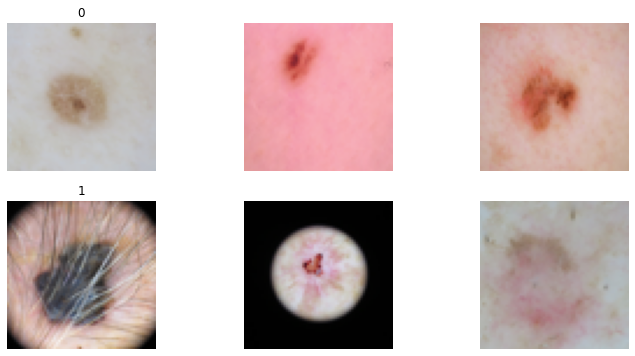

In [31]:
n_samples = 3  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df_balanced.sort_values(['LABEL']).groupby('LABEL')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['JPG'])
        c_ax.axis('off')

In [262]:
# preparing the model 

X = np.asarray(df_balanced['JPG'].tolist())
X = X/255  
Y=df_balanced['LABEL']  
#Y_cat = to_categorical(Y, num_classes=7) 
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [263]:
Y

0        0
1        1
2        0
3        0
4        1
        ..
19659    0
19660    1
19661    1
19662    1
19663    1
Name: LABEL, Length: 19664, dtype: int32

In [264]:
import autokeras as ak

In [265]:
# Autokeras model

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the image classifier with training data.
history = clf.fit(x_train, y_train)

Trial 1 Complete [00h 20m 11s]
val_loss: 0.522611141204834

Best val_loss So Far: 0.522611141204834
Total elapsed time: 00h 20m 11s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
461/461 [==============================] - 103s 221ms/step - loss: 0.5575 - accuracy: 0.7044
Epoch 2/5
461/461 [==============================] - 102s 221ms/step - loss: 0.5248 - accuracy: 0.7307
Epoch 3/5
461/461 [==============================] - 102s 221ms/step - loss: 0.5042 - accuracy: 0.7488
Epoch 4/5
461/461 [==============================] - 103s 223ms/step - loss: 0.4901 - accuracy: 0.7598
Epoch 5/5
461/461 [==============================] - 104s 224ms/step - loss: 0.4749 - accuracy: 0.7685


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [266]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0     

In [267]:
# Evaluating the model

print(clf.evaluate(x_test, y_test))

154/154 [==============================] - 6s 36ms/step - loss: 0.5082 - accuracy: 0.7504
[0.5082272291183472, 0.7504068613052368]


In [292]:
y=df_balanced

x=y['JPG'].sample(1)
image  = np.asarray(x.tolist())

predicted_y = clf.predict(image)




print('Actual type:',y['LABEL'].iloc[x.index[0]])
print('Predicted type:')
#print(x1)
#print(round(x1.max()))
classes = np.argmax(predicted_y, axis = 1)
if predicted_y == 0:
    print('NO')
if predicted_y == 1:
    print('YES')
# print(predicted_y)


1/1 [==============================] - 0s 11ms/step
Actual type: 1
Predicted type:
NO


In [256]:
x.index[0]

18118

In [183]:
df_balanced.iloc[4113]

image                                            ISIC_0057937
MEL                                                       0.0
NV                                                        0.0
BCC                                                       1.0
AK                                                        0.0
BKL                                                       0.0
DF                                                        0.0
VASC                                                      0.0
SCC                                                       0.0
UNK                                                       0.0
POSITIVE                                                  1.0
NEGATIVE                                                  0.0
LABEL                                                     1.0
folder      C:\Users\User\Downloads\ISIC_2019_Training_Inp...
path        C:\Users\User\Downloads\ISIC_2019_Training_Inp...
JPG         [[[123, 96, 85], [130, 104, 93], [137, 109, 10...
Name: 41

In [299]:
print(predicted_y)

[[0.]]


In [298]:
y_pred = clf.predict(x_test)
y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

154/154 [==============================] - 6s 40ms/step
[[1903  538]
 [ 689 1786]]


In [ ]:
#  Trying the Sequential model

In [371]:
X = np.asarray(df_balanced['JPG'].tolist())
X = X/255  
Y=df_balanced['LABEL']  
#Y_cat = to_categorical(Y, num_classes=2) 
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [372]:
Y

0        0
1        1
2        0
3        0
4        1
        ..
19659    0
19660    1
19661    1
19662    1
19663    1
Name: LABEL, Length: 19664, dtype: int32

In [374]:
#  Sequential model with 10 hidden layers and labels 0,1 as one column

num_classes = 2

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", 
                 bias_initializer="zeros", 
                 input_shape=(64, 64, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu', 
                 bias_initializer="zeros"))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu',
                bias_initializer="zeros"))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(64))
model.add(Dense(1, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 256)      0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 128)      

In [376]:
batch_size = 10
epochs = 15

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/15
1475/1475 - 331s - loss: 0.5914 - acc: 0.4988 - val_loss: 0.5673 - val_acc: 0.5035 - 331s/epoch - 224ms/step
Epoch 2/15
1475/1475 - 294s - loss: 0.5711 - acc: 0.4988 - val_loss: 0.5553 - val_acc: 0.5035 - 294s/epoch - 199ms/step
Epoch 3/15
1475/1475 - 288s - loss: 0.5543 - acc: 0.4988 - val_loss: 0.5293 - val_acc: 0.5035 - 288s/epoch - 195ms/step
Epoch 4/15
1475/1475 - 277s - loss: 0.5457 - acc: 0.4988 - val_loss: 0.5597 - val_acc: 0.5035 - 277s/epoch - 188ms/step
Epoch 5/15
1475/1475 - 269s - loss: 0.5403 - acc: 0.4988 - val_loss: 0.5158 - val_acc: 0.5035 - 269s/epoch - 182ms/step
Epoch 6/15
1475/1475 - 278s - loss: 0.5379 - acc: 0.4988 - val_loss: 0.5365 - val_acc: 0.5035 - 278s/epoch - 188ms/step
Epoch 7/15
1475/1475 - 260s - loss: 0.5310 - acc: 0.4988 - val_loss: 0.5590 - val_acc: 0.5035 - 260s/epoch - 176ms/step
Epoch 8/15
1475/1475 - 238s - loss: 0.5471 - acc: 0.4988 - val_loss: 0.5333 - val_acc: 0.5035 - 238s/epoch - 161ms/step
Epoch 9/15
1475/1475 - 236s - loss: 0.52

In [352]:
y=df_balanced

x=y['JPG'].sample(1)
image  = np.asarray(x.tolist())

predicted_y = model.predict(image)




print('Actual type:',y['LABEL'].iloc[x.index[0]])
print('Predicted type:')
#print(x1)
#print(round(x1.max()))
#classes = np.argmax(predicted_y, axis = 1)
#if predicted_y == 0:
    #print('NO')
#if predicted_y == 1:
    #print('YES')
print(predicted_y)


1/1 [==============================] - 0s 114ms/step
Actual type: 0
Predicted type:
[[1. 0.]]


In [365]:
y_predict=model.predict(x_test)

154/154 [==============================] - 14s 92ms/step


In [366]:
y_predict

array([[0.24768779, 0.75231224],
       [0.8697653 , 0.1302347 ],
       [0.9920632 , 0.00793672],
       ...,
       [0.23736207, 0.7626379 ],
       [0.6393795 , 0.36062044],
       [0.7498794 , 0.25012055]], dtype=float32)

In [ ]:
# Second sequential model but labeling the types to numpy array

In [384]:
X = np.asarray(df_balanced['JPG'].tolist())
X = X/255  
Y=df_balanced['LABEL']  
Y_cat = to_categorical(Y, num_classes=2) 
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [386]:
Y_cat

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [387]:
num_classes = 2

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", 
                 bias_initializer="zeros", 
                 input_shape=(64, 64, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu', 
                 bias_initializer="zeros"))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu',
                bias_initializer="zeros"))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(64))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 31, 31, 256)      0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 31, 31, 256)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 128)      

In [388]:
batch_size = 10
epochs = 15

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/15
1475/1475 - 261s - loss: 0.6329 - acc: 0.6410 - val_loss: 0.5957 - val_acc: 0.6837 - 261s/epoch - 177ms/step
Epoch 2/15
1475/1475 - 228s - loss: 0.5973 - acc: 0.6865 - val_loss: 0.5590 - val_acc: 0.7244 - 228s/epoch - 155ms/step
Epoch 3/15
1475/1475 - 248s - loss: 0.5638 - acc: 0.7061 - val_loss: 0.5570 - val_acc: 0.6996 - 248s/epoch - 168ms/step
Epoch 4/15
1475/1475 - 242s - loss: 0.5505 - acc: 0.7155 - val_loss: 0.5282 - val_acc: 0.7345 - 242s/epoch - 164ms/step
Epoch 5/15
1475/1475 - 239s - loss: 0.5365 - acc: 0.7233 - val_loss: 0.5644 - val_acc: 0.6766 - 239s/epoch - 162ms/step
Epoch 6/15
1475/1475 - 226s - loss: 0.5339 - acc: 0.7225 - val_loss: 0.5244 - val_acc: 0.7435 - 226s/epoch - 153ms/step
Epoch 7/15
1475/1475 - 224s - loss: 0.5316 - acc: 0.7274 - val_loss: 0.5213 - val_acc: 0.7421 - 224s/epoch - 152ms/step
Epoch 8/15
1475/1475 - 241s - loss: 0.5248 - acc: 0.7339 - val_loss: 0.5178 - val_acc: 0.7417 - 241s/epoch - 163ms/step
Epoch 9/15
1475/1475 - 257s - loss: 0.52

In [ ]:
# Evaluating the model - Better results

In [389]:
y_predict=model.predict(x_test)

154/154 [==============================] - 14s 93ms/step


In [390]:
y_predict

array([[0.01181053, 0.98818946],
       [0.42162526, 0.5783748 ],
       [0.98386246, 0.0161375 ],
       ...,
       [0.32555777, 0.67444223],
       [0.66188973, 0.33811027],
       [0.60755193, 0.39244807]], dtype=float32)

In [424]:
pd_pred=pd.DataFrame(y_predict)

pd_pred=pd_pred[1].to_numpy()

pd_pred


for i in y_pred2:
    

array([0.98818946, 0.5783748 , 0.0161375 , ..., 0.67444223, 0.33811027,
       0.39244807], dtype=float32)

In [417]:
pd_y_predict=[]
for i in pd_pred:
    if i > 0.5:
        pd_y_predict.append(1)
    if i < 0.5:
        pd_y_predict.append(0)

    

In [414]:
pd_y_predict

[1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,


In [418]:
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [419]:
pd_test=pd.DataFrame(y_test)
pd_test=pd_test[1].to_numpy()
pd_test

array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [421]:
from sklearn.metrics import recall_score
recall = recall_score(pd_test, pd_y_predict)
recall

0.7854545454545454